### Clone the DoDUO repository, fetch the data , install the packages

In [ ]:
!git clone https://github.com/megagonlabs/doduo

Cloning into 'doduo'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 18), reused 37 (delta 8), pack-reused 0
Unpacking objects: 100% (55/55), 42.06 KiB | 2.80 MiB/s, done.


In [ ]:
%cd doduo

/content/doduo


In [ ]:
!bash download.sh 

--2023-05-24 17:45:48--  https://doduo-data.s3-us-west-2.amazonaws.com/data.tar.gz
Resolving doduo-data.s3-us-west-2.amazonaws.com (doduo-data.s3-us-west-2.amazonaws.com)... 52.92.226.178, 3.5.81.171, 52.218.245.153, ...
Connecting to doduo-data.s3-us-west-2.amazonaws.com (doduo-data.s3-us-west-2.amazonaws.com)|52.92.226.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106987437 (102M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 102.03M  17.5MB/s    in 6.9s    

2023-05-24 17:45:56 (14.7 MB/s) - ‘data.tar.gz’ saved [106987437/106987437]

./._data
./data/
./data/._msato_cv_4.csv
./data/msato_cv_4.csv
./data/._msato_cv_2.csv
./data/msato_cv_2.csv
./data/._msato_cv_3.csv
./data/msato_cv_3.csv
./data/._msato_cv_1.csv
./data/msato_cv_1.csv
./data/._msato_cv_0.csv
./data/msato_cv_0.csv
./data/._table_col_type_serialized.pkl
./data/table_col_type_serialized.pkl
./data/._sato_cv_3.csv
./data/sato_cv_3.csv
./data/._s

In [ ]:
!pip install numpy -q
!pip install pandas -q
!pip install scikit-learn -q
!pip install scipy -q
!pip install torch -q
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.4 MB/s eta 0:00:00


### Masked Column Prediction

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import BertTokenizer
from transformers import DataCollatorForLanguageModeling
from torch.utils.data.dataset import Dataset
import random
from transformers import AdamW
from tqdm import tqdm  # for our progress bar
import pickle
import math
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### Custom Functions

In [ ]:
def modify_df_list(df):
  '''
  return list with grouped values with respect to a df
  '''
  row_list = []
  new_row_list = []
  for (index, group_df) in df.groupby('table_id'):

      row_list.append(group_df.data.values.tolist() )

  for r in row_list:
    new_row_list.append(' | '.join(r))
  return new_row_list

def calculate_perplexity(avg_train_loss,avg_val_loss):
  '''
  calculate perplexity with respect to loss
  '''
  train_perplexity_list= []
  val_perplexity_list = []
  for i,t in enumerate(avg_train_loss):
    train_perplexity_list.append(math.exp(avg_train_loss[i]))
    val_perplexity_list.append(math.exp(avg_val_loss[i]))
  return train_perplexity_list , val_perplexity_list
  

In [ ]:
# loading the data
with open('/content/doduo/data/table_col_type_serialized.pkl', 'rb') as f:
    all_data = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 0.22.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# Defining the threshold of training data
threshold = 250000

train_df = all_data.get('train').head(threshold)
val_df = all_data.get('dev')

train_df_list = modify_df_list(train_df)
val_df_list = modify_df_list(val_df)

In [ ]:
class Custom_MCP_Dataset(Dataset):
    def __init__(self,examples):
        self.examples = examples
        self.selections = random.sample(range(0,len(examples)), int(0.2*len(examples)) )
        
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        res = tokenizer(self.examples[i], return_tensors='pt', max_length=150, truncation=True, padding='max_length')
        res.input_ids = torch.where(res.input_ids == 1064, 102, res.input_ids)
        res['labels'] = res.input_ids.detach().clone()
        if i in self.selections:
          # find the positions of the [SEP] tokens
          sep_positions = torch.where(res.input_ids == tokenizer.sep_token_id)[1]
          # create a new tensor of the same shape as the input tensor
          masked_tensor = res.input_ids.clone()
          # replace the values between the [SEP] tokens with the MASK token
          for i in range(sep_positions.shape[0]-1):
              start_idx = sep_positions[i] + 1
              end_idx = sep_positions[i+1]
              masked_tensor[0, start_idx:end_idx] = tokenizer.mask_token_id
              res.input_ids = masked_tensor

        else:
          pass

        res.input_ids = res.input_ids.squeeze()
        res.labels = res.labels.squeeze()
        res.token_type_ids = res.token_type_ids.squeeze()
        res.attention_mask = res.attention_mask.squeeze()

        return {
        'input_ids':res.input_ids.squeeze(),  
        'token_type_ids':res.token_type_ids.squeeze(),  
        'attention_mask':res.attention_mask.squeeze(),  
        'labels':res.labels.squeeze(),  

        }

##### Example Dataset

In [ ]:
train_df[train_df.table_id.str.contains('10535445-4')]

,table_id,labels,data,label_ids
248689,10535445-4,"[film.actor, tv.tv_personality, people.person]",Stacy Keibler Giselle Fernandez Tatum O'Neal S...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
248690,10535445-4,"[tv.tv_actor, film.actor, tv.tv_personality, p...",Master P Lisa Rinna Tatum O'Neal Master P Mast...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
example_MSP_dataset = Custom_MCP_Dataset(train_df_list[:10000])
example_MSP_loader = torch.utils.data.DataLoader(example_MSP_dataset, batch_size=64, shuffle=True)


In [ ]:
tokenizer.decode(example_MSP_dataset[7547].get('input_ids'))

'[CLS] rene clement william beaudine r. g. springsteen daniel mann william castle george axelrod mark robson david lowell rich boris sagal joseph barbera, william hanna ronald neame delbert mann earl bellamy henry levin cornel wilde henry hathaway norman panama russell rouse daniel mann don sharp michael d. moore arthur hiller bert i. gordon david lowell rich terence young richard brooks curtis harrington andrew v. mclaglen coleman francis burt kennedy bernard mceveety john waters emile de antonio norman jewison [SEP] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]'

In [ ]:
tokenizer.decode(example_MSP_dataset[7547].get('labels'))

'[CLS] rene clement william beaudine r. g. springsteen daniel mann william castle george axelrod mark robson david lowell rich boris sagal joseph barbera, william hanna ronald neame delbert mann earl bellamy henry levin cornel wilde henry hathaway norman panama russell rouse daniel mann don sharp michael d. moore arthur hiller bert i. gordon david lowell rich terence young richard brooks curtis harrington andrew v. mclaglen coleman francis burt kennedy bernard mceveety john waters emile de antonio norman jewison [SEP] kirk douglas, charles boyer, leslie caron, glenn ford, yves montand, alain delon, jean - paul belmondo simone signoret john lupton, narda onyx dana andrews, jane russell sophia loren, peter finch [SEP]'

In [ ]:
tokenizer.decode(example_MSP_dataset[2350].get('input_ids'))

"[CLS] stacy keibler giselle fernandez tatum o'neal stacy keibler drew lachey drew lachey lisa rinna stacy keibler stacy keibler drew lachey stacy keibler drew lachey stacy keibler lisa rinna drew lachey jerry rice drew lachey [SEP] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [ ]:
tokenizer.decode(example_MSP_dataset[2350].get('labels'))

"[CLS] stacy keibler giselle fernandez tatum o'neal stacy keibler drew lachey drew lachey lisa rinna stacy keibler stacy keibler drew lachey stacy keibler drew lachey stacy keibler lisa rinna drew lachey jerry rice drew lachey [SEP] master p lisa rinna tatum o'neal master p master p jerry rice tia carrere master p jerry rice stacy keibler [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

#### Training via MCP

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
val_MCP_dataset = Custom_MCP_Dataset(val_df_list)
val_MCP_loader = torch.utils.data.DataLoader(val_MCP_dataset, batch_size=64, shuffle=True)

In [ ]:
epochs = 6
avg_train_loss = []
avg_val_loss = []

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0

    train_MCP_dataset = Custom_MCP_Dataset(train_df_list)
    train_MCP_loader = torch.utils.data.DataLoader(train_MCP_dataset, batch_size=64, shuffle=True)

    loop = tqdm(train_MCP_loader,total=len(train_MCP_loader), desc='Epoch [{}/{}]'.format(epoch, epochs - 1))
    for batch in loop:
        model.train()
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, 
                        attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()

        train_loss = train_loss + loss.item()
        loop.set_postfix(loss=loss.item())

    val_loop = tqdm(val_MCP_loader,total=len(val_MCP_loader), desc='Validation')
    for idx, batch in enumerate(val_loop):
      model.eval()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      with torch.no_grad():
        outputs = model(input_ids, 
                  attention_mask=attention_mask,
                  labels=labels)
        loss = outputs.loss
        val_loss = val_loss + loss.item()

    avg_train_loss.append(train_loss/ len(train_MCP_loader))
    avg_val_loss.append(val_loss/ len(val_MCP_loader))

Validation: 100%|██████████| 76/76 [00:16<00:00,  4.74it/s]


In [ ]:
torch.save(model.state_dict(),"/content/MSP_model.pt")

In [ ]:
train_perplexity_list , val_perplexity_list = calculate_perplexity(avg_train_loss,avg_val_loss)

##### Graphs

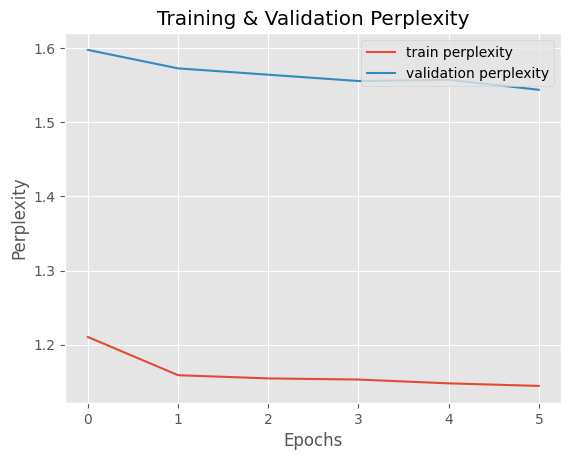

<Figure size 2000x2000 with 0 Axes>

In [ ]:
N = 6
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train_perplexity_list, label="train perplexity")
plt.plot(np.arange(0, N), val_perplexity_list, label="validation perplexity")

plt.title("Training & Validation Perplexity")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.legend(loc="upper right")
plt.figure(figsize = (20,20))
plt.show()

### Inference

In [ ]:
from doduo.model import BertForMultiOutputClassification, BertMultiPairPooler
from doduo.dataset import TURLColTypeTablewiseDataset , collate_fn
from torch.utils.data import DataLoader, RandomSampler
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#### Inference Functions

In [ ]:
def f1_score_multilabel(true_list, pred_list):
    conf_mat = multilabel_confusion_matrix(np.array(true_list),
                                           np.array(pred_list))
    agg_conf_mat = conf_mat.sum(axis=0)
    # Note: Pos F1
    # [[TN FP], [FN, TP]] if we consider 1 as the positive class
    p = agg_conf_mat[1, 1] / agg_conf_mat[1, :].sum()
    r = agg_conf_mat[1, 1] / agg_conf_mat[:, 1].sum()
    
    micro_f1 = 2 * p * r / (p  + r) if (p + r) > 0 else 0.
    class_p = conf_mat[:, 1, 1] /  conf_mat[:, 1, :].sum(axis=1)
    class_r = conf_mat[:, 1, 1] /  conf_mat[:, :, 1].sum(axis=1)
    class_f1 = np.divide(2 * (class_p * class_r), class_p + class_r,
                         out=np.zeros_like(class_p), where=(class_p + class_r) != 0)
    class_f1 = np.nan_to_num(class_f1)
    macro_f1 = class_f1.mean()
    return (micro_f1, macro_f1, class_f1, conf_mat)



def doduo_inference(test_dataloader,doduo_pretrained):
  '''
  Inference with respect to the test_dataloader and the pretrained model
  '''
  ts_pred_list = []
  ts_true_list = []
  # Test
  for batch_idx, batch in enumerate(test_dataloader):

          # Multi-column
          logits, = doduo_pretrained(batch["data"].T)
          if len(logits.shape) == 2:
              logits = logits.unsqueeze(0)
          cls_indexes = torch.nonzero(
              batch["data"].T == tokenizer.cls_token_id)
          filtered_logits = torch.zeros(cls_indexes.shape[0],
                                        logits.shape[2]).to(device)
          for n in range(cls_indexes.shape[0]):
              i, j = cls_indexes[n]
              logit_n = logits[i, j, :]
              filtered_logits[n] = logit_n
          if "sato" in task:
              ts_pred_list += filtered_logits.argmax(
                  1).cpu().detach().numpy().tolist()
              ts_true_list += batch["label"].cpu().detach().numpy(
              ).tolist()
          elif "turl" in task:
              if "turl-re" in task:  # turl-re-colpair
                  all_preds = (filtered_logits >= math.log(0.5)
                                ).int().detach().cpu().numpy()
                  all_labels = batch["label"].cpu().detach().numpy()
                  idxes = np.where(all_labels > 0)[0]
                  ts_pred_list += all_preds[idxes, :].tolist()
                  ts_true_list += all_labels[idxes, :].tolist()
              elif task == "turl":
                  ts_pred_list += (filtered_logits >= math.log(0.5)
                                    ).int().detach().cpu().tolist()
                  ts_true_list += batch["label"].cpu().detach(
                  ).numpy().tolist()
            
  return ts_true_list , ts_pred_list

#### Load Pretrained DODUO model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
task = 'turl'


doduo_pretrained = BertForMultiOutputClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=255,
    output_attentions=False,
    output_hidden_states=False,
)


model_path = '/content/doduo/model/turlturl-re-colpair_mosato_bert_bert-base-uncased-bs16-ml-16__turl-1.00_turl-re-1.00=turl_best_micro_f1.pt'
doduo_pretrained.load_state_dict(torch.load(model_path, map_location=device))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultiOutputClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMultiOutputClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiOutputClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiOutputClassification were not initialized from the model c

<All keys matched successfully>

In [ ]:
doduo_pretrained.encoder = model.bert.encoder

#### Test Dataloader & Inference

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


filepath = "data/table_col_type_serialized.pkl"
dataset_cls = TURLColTypeTablewiseDataset

batch_size = 16
max_length = 32


test_dataset = dataset_cls(filepath=filepath,
                            split="test",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            multicol_only=False,
                            device=device)
test_dataloader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              collate_fn=collate_fn)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 0.22.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
tokenizer.decode(test_dataset[1].get('data'))

'[CLS] adelaide, sa barker, sa boothby, sa denison, tas eden - monaro, nsw grey, sa hume, nsw lilley, qld [SEP] [CLS] fred stacey archie cameron * grenfell price arthur beck john perkins oliver badman * thomas collins william jolly frank baker william mccall charles marr walter nairn eric [SEP] [CLS] cyril chambers archie cameron thomas sheehy john gaha allan fraser edgar russell arthur fuller james hadley charles adermann fred daly les haylen tom burke thomas williams [SEP]'

In [ ]:
doduo_pretrained.to(device)

ts_true_list , ts_pred_list = doduo_inference(test_dataloader,doduo_pretrained)
ts_micro_f1, ts_macro_f1, ts_class_f1, ts_conf_mat = f1_score_multilabel(ts_true_list, ts_pred_list)

In [ ]:
print('ts_micro_f1 : {}'.format(ts_micro_f1))
print('ts_macro_f1 : {}'.format(ts_macro_f1))

ts_micro_f1 : 0.9086148515631153
ts_macro_f1 : 0.730616411747839
